# 预测房屋出租状况

## 项目简介

一个房屋共享公司(如Airbnb)想要帮助房屋供应商为他们的房屋设定一个合理的价格。其中一个关键的步骤是建立一个模型来预测
在一定条件下购买一个房间的可能性(以特定的特征和日期来描述)。我们的历史数据：[训练集](http://www.menet.umn.edu/~zwang/files/case2_training.csv)有50000个数据，[测试集](http://www.menet.umn.edu/~zwang/files/case2_testing.csv)有20000个数据。它们有以下特征：

* ID:数据标识
* Region:房屋所属的区域(取1到10之间的值的整数)
* Date:租出的日期(1‐365之间的整数，这里我们只考虑1天的请求)
* Weekday:星期几(1‐7之间的整数)
* Apartment/Room:房间是整个公寓(1)还是一个房间(0)
* Beds:房屋内床的数量(1‐4之间的整数)
* Review：平均评分(1到5之间的连续变量)
* Pic Quality：房屋图片的质量(0到1之间的连续变量)
* Price:房屋的历史标价(连续变量)
* Accept:这个房屋是否被接受(有人租了它，1)或没有(0)

我们的目标：建立一个模型来预测每个测试集的购买可能性。我们会采用逻辑回归，决策树，随机森林，神经网络和SVM算法来分别建立模型，并选择相对优秀的模型来预测测试集。

## 特征转换

我们首先读入训练集数据，并检查有无缺失值。

In [1]:
#读入训练集数据
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

train=pd.read_csv('case2_training.csv')
train=train.copy()

#检查缺失值
miss_n=train.isnull().sum()
print(miss_n)

ID             0
Region         0
Date           0
Weekday        0
Apartment      0
Beds           0
Review         0
Pic Quality    0
Price          0
Accept         0
dtype: int64


以上可以看出训练集没有缺失值。接下来我们检查是否存在共线性的特征，通过绘出各个特征之间相关性的方法：

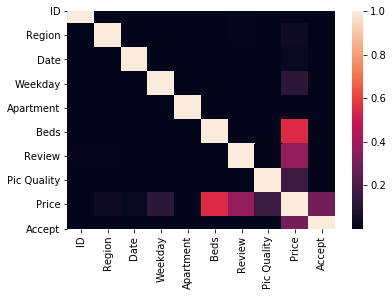

In [2]:
#绘出各个特征之间相关系数
import seaborn as sns
corrmat=train.corr().abs()
sns.heatmap(corrmat)
plt.show()

由上图可知，不存在高共线性的特征。接下来我们深入各特征的商业内涵。首先是‘Price’

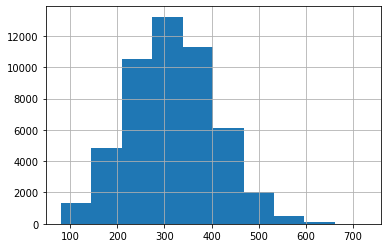

In [3]:
train['Price'].hist()

从上图得知：‘Price’是一个跨度比较大的连续变量，我们将它标准化。另外，‘ID’也和预测结果无关，因为它代表每个数据的标识，我们先将它删去。

In [4]:
#标准化'Price'变量
train['normalized_price'] = (train['Price'] - train['Price'].mean()) / (train['Price'].std())
del train['Price']

#删去‘ID’变量
del train['ID']

其次，对于‘Date’,是租出的日期(1‐365之间的整数），为了简便，我们可以将日期归类为月份（1-12）或者季度（1-4）。经检测，变季度时，模型的auc值更高，所以这里我们把它转换成季度归类。1,2,3,4分别对应着1,2,3,4季度：

In [5]:
#把日期（365天）归类转化为季度（1,2,3,4季度）
def assign_label(h):
    if h >=0 and h < 92:
        return 1
    elif h >= 92 and h <183:
        return 2
    elif h >=183 and h <275 :
        return 3
    elif h >= 275 and h < 366:
        return 4   

train["date_label"] = train["Date"].apply(assign_label)
del train['Date']

另外，对于‘Weekday’特征，我们将其所对应的1-7天转化成周末和平日。我们知道，在周末，周五和周六晚上酒店的入住率会比较高，而周日到周四晚上的平日，入住率会相对较低。因此，我们将周日到周四归为类别1，周五和周六归为类别2:

In [6]:
#将周日到周四归为类别1，周五和周六归为类别2
def assign_week(h):
    if h >=0 and h < 5 or h>=7:
        return 1
    elif h >= 5 and h <7:
        return 2

train["week_label"] = train["Weekday"].apply(assign_week)
del train['Weekday']

最后，我们将原训练集里代表类别的特征‘Region’虚拟化处理：

In [7]:
#将原训练集里代表类别的特征‘Region’虚拟化处理
dum=pd.get_dummies(train['Region'],prefix="Region")
train=pd.concat([train,dum],axis=1)
del train['Region']

#转换后的transform_train留作给不同的算法使用
transform_train=train

#显示特征转换后的前五行
train.head()

,Apartment,Beds,Review,Pic Quality,Accept,normalized_price,date_label,week_label,Region_1,Region_2,Region_3,Region_4,Region_5,Region_6,Region_7,Region_8,Region_9,Region_10
0,1,1,4.526975,0.739994,0,-0.932707,1,2,0,0,0,1,0,0,0,0,0,0
1,1,1,4.548455,0.862642,0,0.337202,1,1,0,1,0,0,0,0,0,0,0,0
2,1,2,4.965732,0.515548,0,1.225097,4,2,0,0,0,0,1,0,0,0,0,0
3,1,1,4.752735,0.561547,1,-1.809686,3,1,0,0,1,0,0,0,0,0,0,0
4,1,2,3.890960,0.817142,1,-1.637429,2,1,1,0,0,0,0,0,0,0,0,0


特征转换完之后，下面我们可以开始训练模型了。我们将依次用：逻辑回归，决策树，随机森林，神经网络和SVM算法来训练模型并评估。

## 用逻辑回归算法来训练模型

我们将使用sklearn里的LogisticRegression来训练训练集；并且为了真实的描述模型的准确性，我们将执行K交叉验证：通过 sklearn.model_selection库的cross_val_predict() 函数来实现。

In [8]:
#首先设置忽略warnings
import warnings  
warnings.filterwarnings('ignore')

In [9]:
#逻辑回归算法来训练模型
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression

train=transform_train
#设置惩罚因子，我们加重惩罚错误预测为1的
penalty = {
    0: 1,
    1: 3.6
}

#实例化模型对象:
lr = LogisticRegression(class_weight=penalty)
features =train.columns.drop("Accept")
lr.fit(train[features],train['Accept'])

#使用5重交叉验证进行预测
fitted_labels=cross_val_predict(lr,train[features],train['Accept'],cv=5)
train['fitted_labels']=fitted_labels

训练模型后，我们将评估所预测的训练集结果。我们使用四个指标：auc(曲线下面积），accuracy(准确率），precision(精准率）和recall(召回率），四个指标的对比，我们将在后文给出。

auc : 0.7175635602356261
accuracy : 0.6716
precision : 0.4419339358553947
recall : 0.8176235572654632


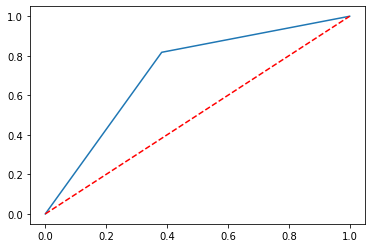

In [10]:
from sklearn.metrics import roc_curve,auc
#计算auc
fpr,tpr,thresholds =roc_curve(train['Accept'],train['fitted_labels'])
auc=auc(fpr,tpr)
print('auc : '+str(auc))

#以fpr假正率为横轴，tpr真征率为纵轴绘出auc曲线
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1],'r--')

from sklearn.metrics import accuracy_score,precision_score,recall_score
#计算accuracy
accuracy = accuracy_score(train['Accept'],train['fitted_labels'])
print('accuracy : '+str(accuracy))
#计算precision
precision =precision_score(train['Accept'],train['fitted_labels'])
print('precision : '+str(precision))
#计算recall
recall=recall_score(train['Accept'],train['fitted_labels'])
print('recall : '+str(recall))

由上得出逻辑回归算法预测的auc为 0.7175635602356261。

## 决策树算法

我们将使用sklearn里的DecisionTreeClassifier来训练训练集；同样，为了真实的描述模型的准确性，我们将执行K交叉验证：通过 sklearn.model_selection库的cross_val_predict() 函数来实现。

In [11]:
#使用决策树算法来训练训练集
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict

train=transform_train

#设置惩罚因子，我们加重惩罚错误预测为1的
penalty = {
    0: 1,
    1: 3.6
}

features =train.columns.drop("Accept")
#实例化模型对象；最大树深设为10；节点被分割之前的最小行数设为2，即是具有2行的节点将不会被分割，而是变成叶子
clf = DecisionTreeClassifier(class_weight=penalty,min_samples_split=2,max_depth=10)
clf.fit(train[features], train['Accept'])

#使用5重交叉验证进行预测
fitted_labels=cross_val_predict(clf,train[features],train['Accept'],cv=5)
train['fitted_labels']=fitted_labels

同样，训练模型后，我们将评估所预测的训练集结果。我们使用四个指标：auc(曲线下面积），accuracy(准确率），precision(精准率）和recall(召回率），四个指标的对比，我们将在后文给出。

auc : 0.6947245848853494
accuracy : 0.63256
precision : 0.4110427200117242
recall : 0.8300532701982836


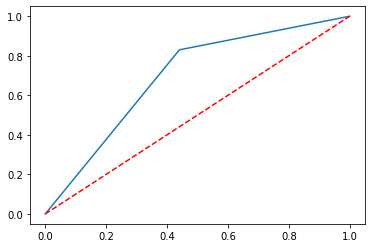

In [12]:
from sklearn.metrics import roc_curve,auc
#计算auc
fpr,tpr,thresholds =roc_curve(train['Accept'],train['fitted_labels'])
auc=auc(fpr,tpr)
print('auc : '+str(auc))

#以fpr假正率为横轴，tpr真征率为纵轴绘出auc曲线
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1],'r--')

from sklearn.metrics import accuracy_score,precision_score,recall_score
#计算accuracy
accuracy = accuracy_score(train['Accept'],train['fitted_labels'])
print('accuracy : '+str(accuracy))
#计算precision
precision =precision_score(train['Accept'],train['fitted_labels'])
print('precision : '+str(precision))
#计算recall
recall=recall_score(train['Accept'],train['fitted_labels'])
print('recall : '+str(recall))

由上得出决策树算法预测的auc为 0.6948835773388841。

## 随机森林算法

通常，随机森林能减少过度拟合，并且总体上提高模型的准确性。我们将使用sklearn.ensemble里的RandomForestClassifier来训练训练集；同样，为了真实的描述模型的准确性，我们将执行K交叉验证：通过 sklearn.model_selection库的cross_val_predict() 函数来实现。

In [13]:
#使用随机森林算法来训练训练集
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier

train=transform_train

#设置惩罚因子，我们加重惩罚错误预测为1的
penalty = {
    0: 1,
    1: 3.6
}

#实例化模型对象：最大树深设为11；节点被分割之前的最小行数设为2，即是具有2行的节点将不会被分割，而是变成叶子
rf =RandomForestClassifier(class_weight=penalty,min_samples_split=2,max_depth=11)
features =train.columns.drop("Accept")
rf.fit(train[features],train['Accept'])

#使用5重交叉验证进行预测
fitted_labels=cross_val_predict(rf,train[features],train['Accept'],cv=5)
train['fitted_labels']=fitted_labels

同样，训练模型后，我们将评估所预测的训练集结果。我们使用四个指标：auc(曲线下面积），accuracy(准确率），precision(精准率）和recall(召回率），四个指标的对比，我们将在后文给出。

auc : 0.7010618705296477
accuracy : 0.64276
precision : 0.4186994911703083
recall : 0.8279816513761468


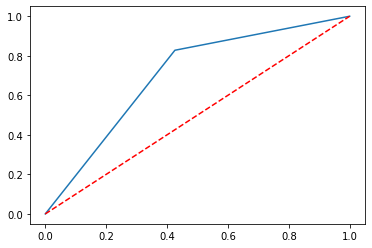

In [15]:
from sklearn.metrics import roc_curve,auc
#计算auc
fpr,tpr,thresholds =roc_curve(train['Accept'],train['fitted_labels'])
auc=auc(fpr,tpr)
print('auc : '+str(auc))

#以fpr假正率为横轴，tpr真征率为纵轴绘出auc曲线
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1],'r--')

from sklearn.metrics import accuracy_score,precision_score,recall_score
#计算accuracy
accuracy = accuracy_score(train['Accept'],train['fitted_labels'])
print('accuracy : '+str(accuracy))
#计算precision
precision =precision_score(train['Accept'],train['fitted_labels'])
print('precision : '+str(precision))
#计算recall
recall=recall_score(train['Accept'],train['fitted_labels'])
print('recall : '+str(recall))

由上我们得出，随机森林算法的auc为 0.7010618705296477

## 神经网络

我们将使用sklearn.neural_network里的MLPClassifier来训练训练集；同样，为了真实的描述模型的准确性，我们将执行K交叉验证：通过 sklearn.model_selection库的cross_val_predict() 函数来实现。

In [19]:
#使用神经网络来训练训练集
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_predict

train=transform_train

features =train.columns.drop('Accept')

#实例化模型对象：隐藏层的数量是3，没层的神经元数量分别是2,6,10；
#使用激活参数指定所有层中的激活函数:logistic：sigmoid函数；tanh：双曲正切函数；relu:ReLU函数;identity：正比例函数
mlp=MLPClassifier(hidden_layer_sizes=(2,6,10),activation='logistic')
mlp.fit(train[features],train['Accept'])

#使用5重交叉验证进行预测
fitted_labels=cross_val_predict(mlp,train[features],train['Accept'],cv=4)
train['fitted_labels']=fitted_labels

同样，训练模型后，我们将评估所预测的训练集结果。我们使用四个指标：auc(曲线下面积），accuracy(准确率），precision(精准率）和recall(召回率），四个指标的对比，我们将在后文给出。

神经网络：
auc : 0.5878284720575782
accuracy : 0.73642
precision : 0.5247466588338963
recall : 0.26435335898194734


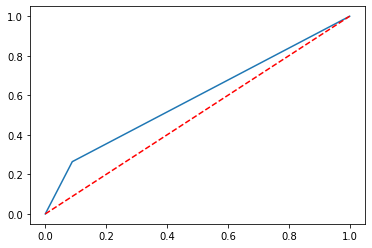

In [21]:
from sklearn.metrics import roc_curve,auc
#计算auc
fpr,tpr,thresholds =roc_curve(train['Accept'],train['fitted_labels'])
auc=auc(fpr,tpr)
print('神经网络：')
print('auc : '+str(auc))

#以fpr假正率为横轴，tpr真征率为纵轴绘出auc曲线
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1],'r--')

from sklearn.metrics import accuracy_score,precision_score,recall_score
#计算accuracy
accuracy = accuracy_score(train['Accept'],train['fitted_labels'])
print('accuracy : '+str(accuracy))
#计算precision
precision =precision_score(train['Accept'],train['fitted_labels'])
print('precision : '+str(precision))
#计算recall
recall=recall_score(train['Accept'],train['fitted_labels'])
print('recall : '+str(recall))

由上，我们得出神经网络算法的auc为 0.5878284720575782

## 支持向量机SVM算法

相对于神经网络，支持向量机算法结构简单，性能也有明显的提升。我们将使用sklearn里的svm来训练训练集；同样，为了真实的描述模型的准确性，我们将执行K交叉验证：通过 sklearn.model_selection库的cross_val_predict() 函数来实现。

In [22]:
#使用支持向量机来训练模型
from sklearn import svm
from sklearn.model_selection import cross_val_predict

train=transform_train

#设置惩罚因子，我们加重惩罚错误预测为1的
penalty = {
    0: 1,
    1: 3.6
}

features =train.columns.drop('Accept')

#实例化模型对象：
model = svm.SVC(class_weight=penalty) 
model.fit(train[features],train['Accept'])

#使用5重交叉验证进行预测
fitted_labels=cross_val_predict(model,train[features],train['Accept'],cv=5)
train['fitted_labels']=fitted_labels

同样，训练模型后，我们将评估所预测的训练集结果。我们使用四个指标：auc(曲线下面积），accuracy(准确率），precision(精准率）和recall(召回率），四个指标的对比，我们将在后文给出。

支持向量机SVM：
auc : 0.7123324850382994
accuracy : 0.62896
precision : 0.4137612165216796
recall : 0.8938295353654927


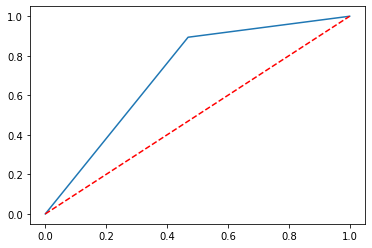

In [25]:
from sklearn.metrics import roc_curve,auc
#计算auc
fpr,tpr,thresholds =roc_curve(train['Accept'],train['fitted_labels'])
auc=auc(fpr,tpr)
print('支持向量机SVM：')
print('auc : '+str(auc))

#以fpr假正率为横轴，tpr真征率为纵轴绘出auc曲线
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1],'r--')

from sklearn.metrics import accuracy_score,precision_score,recall_score
#计算accuracy
accuracy = accuracy_score(train['Accept'],train['fitted_labels'])
print('accuracy : '+str(accuracy))
#计算precision
precision =precision_score(train['Accept'],train['fitted_labels'])
print('precision : '+str(precision))
#计算recall
recall=recall_score(train['Accept'],train['fitted_labels'])
print('recall : '+str(recall))

由上，可以得出支持向量机算法的auc值是0.7123324850382994。

## 选择模型及预测测试集

综上，逻辑回归算法的auc值最高，为0.7175635602356261，因此我们本例中将选择该算法所生成的模型对测试集进行预测。我们选择auc作为主要指标的原因是auc指标可以无视样本目标项的不均衡分布。

首先，我们对测试集也做如上的特征转换处理：

In [30]:
#对测试集也做如上的特征转换处理
test_original=pd.read_csv('case2_testing.csv')
test=test_original.copy()

#标准化'Price'变量
test['normalized_price'] = (test['Price'] - test['Price'].mean()) / (test['Price'].std())
del test['Price']
#删去‘ID’变量
del test['ID']


#把日期（365天）归类转化为季度（1,2,3,4季度）
def assign_label(h):
    if h >=0 and h < 92:
        return 1
    elif h >= 92 and h <183:
        return 2
    elif h >=183 and h <275 :
        return 3
    elif h >= 275 and h < 366:
        return 4   
test["date_label"] = test["Date"].apply(assign_label)
del test['Date']


#将周日到周四归为类别1，周五和周六归为类别2
def assign_week(h):
    if h >=0 and h < 5 or h>=7:
        return 1
    elif h >= 5 and h <7:
        return 2

test["week_label"] = test["Weekday"].apply(assign_week)
del test['Weekday']


#将原测试集里代表类别的特征‘Region’虚拟化处理
dum=pd.get_dummies(test['Region'],prefix="Region")
test=pd.concat([test,dum],axis=1)
del test['Region']

#显示特征转换后的前五行
test.head()

,Apartment,Beds,Review,Pic Quality,normalized_price,date_label,week_label,Region_1,Region_2,Region_3,Region_4,Region_5,Region_6,Region_7,Region_8,Region_9,Region_10
0,1,1,4.923078,0.683932,-0.341719,1,1,1,0,0,0,0,0,0,0,0,0
1,1,1,4.842211,0.958800,-0.230183,1,1,0,0,0,0,0,0,0,0,1,0
2,1,3,4.702331,0.500134,0.742937,4,1,0,1,0,0,0,0,0,0,0,0
3,1,1,4.388125,0.986082,-1.210650,4,1,0,0,0,0,0,0,0,1,0,0
4,0,1,3.868994,0.652980,-0.333568,4,1,0,0,1,0,0,0,0,0,0,0


In [31]:
#用前面已训练的逻辑回归模型lr对测试集进行预测
prediction=lr.predict(test)
test['possibility']=prediction

test.head()

,Apartment,Beds,Review,Pic Quality,normalized_price,date_label,week_label,Region_1,Region_2,Region_3,Region_4,Region_5,Region_6,Region_7,Region_8,Region_9,Region_10,possibility
0,1,1,4.923078,0.683932,-0.341719,1,1,1,0,0,0,0,0,0,0,0,0,1
1,1,1,4.842211,0.958800,-0.230183,1,1,0,0,0,0,0,0,0,0,1,0,1
2,1,3,4.702331,0.500134,0.742937,4,1,0,1,0,0,0,0,0,0,0,0,1
3,1,1,4.388125,0.986082,-1.210650,4,1,0,0,0,0,0,0,0,1,0,0,1
4,0,1,3.868994,0.652980,-0.333568,4,1,0,0,1,0,0,0,0,0,0,0,0


In [32]:
#导出所预测的测试集结果
test['ID']=test_original['ID']
test_result=test[['ID','possibility']]

test_result.to_csv('./test_result1.csv')
test_result.head()

,ID,possibility
0,1,1
1,2,1
2,3,1
3,4,1
4,5,0


## 指标对比：accuracy(准确率），precision(精准率）和recall(召回率）

accuracy(准确率）：在这里我们不用准确率作为主要指标，因为在二分类的正反比例不均衡的情况下，accuracy(准确率）的参考较低。例如本例中，训练集目标项的0所占的比例约为70%，所以即使模型全部预测结果为0，准确率仍等达到70%。训练集目标项的分布如下：

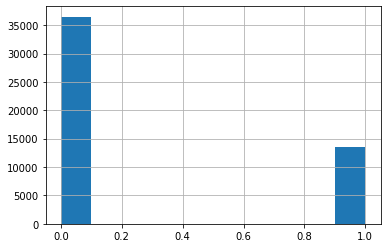

In [26]:
transform_train['Accept'].hist()

recall(召回率）：召回率的定义为实际为正的样本中被预测为正样本的概率。召回率越高，代表实际能租出去的房子被预测出来的概率就越高。

precision(精准率）:精准率的含义为在所有被预测为正的样本中，实际为正的样本的概率。精准率越低，说明有较多的0样本被预测成了1，即是较多不合理价格的房子被预测为能租出去。这样就导致一个比较严重的后果：房子可能有较长时间的空置，这样无疑导致较大的损失。因为我们都知道，即使稍微便宜一点租出去，也比租不出去好。因此在本例中指标重要性方面：precision(精准率）>recall(召回率）>accuracy(准确率。

综上：本例中指标重要性方面：precision(精准率）>recall(召回率）>accuracy(准确率）